In [21]:
from pathlib import Path
import numpy as np
import random

WINDOW_DIR = Path("../data/processed/sisfall/windows")

sample_file = random.choice(list(WINDOW_DIR.glob("*.npz")))
sample_file = WINDOW_DIR / "F07_SA02_R01.npz"  # Specific file for demonstration

data = np.load(sample_file, allow_pickle=True)
X, y, meta = data["X"], data["y"], data["meta"].item()

print("File:", sample_file.name)
print("X shape:", X.shape)   # (num_windows, window_size, num_channels)
print("y shape:", y.shape)
print("Meta:", meta)
print("Fall windows:", sum(y), "/", len(y))

File: F07_SA02_R01.npz
X shape: (28, 200, 6)
y shape: (28,)
Meta: {'activity': 'F07', 'subject': 'SA02', 'group': 'young', 'trial': 'R01', 'is_fall': 1}
Fall windows: 5 / 28


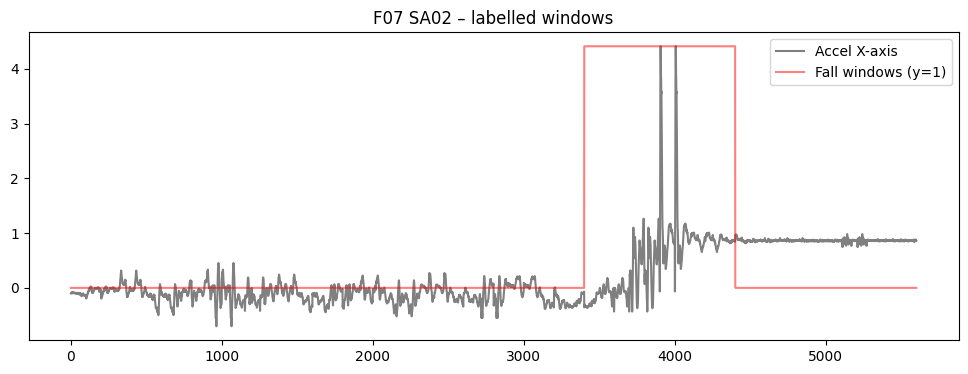

In [22]:
import matplotlib.pyplot as plt

# Flatten all windows back to 1D (just for visualization)
signal_x_flat = X.reshape(-1, X.shape[-1])[:,0]  # plot X-axis 
# signal_y_flat = X.reshape(-1, X.shape[-1])[:,1]  # plot Y-axis 
# signal_z_flat = X.reshape(-1, X.shape[-1])[:,2]  # plot Z-axis 
labels_flat = np.repeat(y, X.shape[1])

plt.figure(figsize=(12, 4))
plt.plot(signal_x_flat, color="gray", label="Accel X-axis")
# plt.plot(signal_y_flat, color="blue", label="Accel Y-axis")
# plt.plot(signal_z_flat, color="green", label="Accel Z-axis")
# plt.plot(labels_flat * signal_z_flat.max(), color="red", alpha=0.5, label="Fall windows (y=1)")
plt.plot(labels_flat * signal_x_flat.max(), color="red", alpha=0.5, label="Fall windows (y=1)")

plt.title(f"{meta['activity']} {meta['subject']} – labelled windows")
plt.legend()
plt.show()


In [16]:
from pathlib import Path
import numpy as np
import pandas as pd

records = []
for f in Path("../data/processed/sisfall/windows").glob("*.npz"):
    d = np.load(f, allow_pickle=True)
    y = d["y"]
    meta = d["meta"].item()
    records.append({
        "file": f.name,
        "subject": meta["subject"],
        "activity": meta["activity"],
        "is_fall": meta["is_fall"],
        "num_windows": len(y),
        "num_fall_windows": sum(y)
    })

df = pd.DataFrame(records)
print(df.head())
print("\nTotal fall windows:", df["num_fall_windows"].sum())
print("Total ADL windows:", (df["num_windows"] - df["num_fall_windows"]).sum())


               file subject activity  is_fall  num_windows  num_fall_windows
0  F11_SA05_R01.npz    SA05      F11        1           28                 4
1  F01_SA04_R04.npz    SA04      F01        1           28                 5
2  F11_SA22_R02.npz    SA22      F11        1           28                 5
3  D15_SE04_R02.npz    SE04      D15        0           22                 0
4  D05_SE01_R04.npz    SE01      D05        0           48                 0

Total fall windows: 8657
Total ADL windows: 140735


In [14]:
for f in Path("../data/processed/sisfall/windows").glob("*.npz")[:10]:
    for X in [np.load(f)["X"]]:
        all_vals = np.concatenate([X.reshape(-1, X.shape[-1])])
print("Median:", np.median(all_vals))
print("Range:", all_vals.min(), "→", all_vals.max())


TypeError: 'generator' object is not subscriptable

<Axes: title={'center': 'Fall vs ADL window counts'}, xlabel='is_fall'>

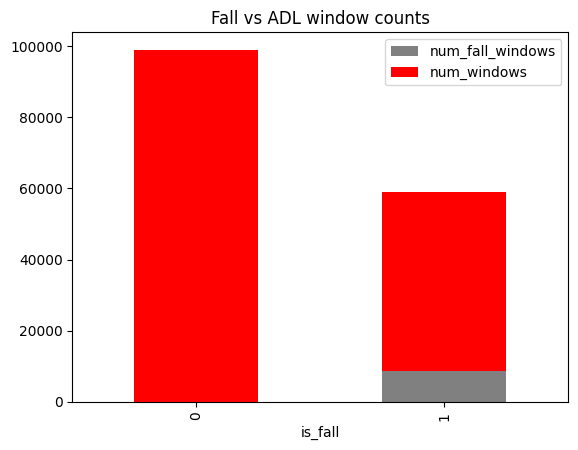

In [17]:
df.groupby("is_fall")[["num_fall_windows","num_windows"]].sum().plot(
    kind="bar", stacked=True, color=["gray", "red"], title="Fall vs ADL window counts"
)

In [18]:
fall_ratios = df[df["is_fall"]==1]["num_fall_windows"] / df[df["is_fall"]==1]["num_windows"]
print(f"Average fraction of fall-labelled windows: {fall_ratios.mean():.3f}")

Average fraction of fall-labelled windows: 0.172
